In [1]:
# required Python imports
import numpy as np
from types import SimpleNamespace

import ftir_funct as f
np.set_printoptions(suppress=True)

module FTIR v.2024.3.19 imported


## Generate database

In [2]:
f.explore_Euler_space(step=7, lower_bounds=(0, 0, 0), upper_bounds=(89, 89, 179))

array([[  0,   0,   0],
       [  0,   0,   7],
       [  0,   0,  14],
       ...,
       [ 84,  84, 161],
       [ 84,  84, 168],
       [ 84,  84, 175]])

In [3]:
# generate Euler angles each 7 degrees and store in the database
database = SimpleNamespace(euler=f.explore_Euler_space(step=7, lower_bounds=(0, 0, 0), upper_bounds=(89, 89, 179)))
database.euler.shape

(4394, 3)

In [4]:
# Generate a mesh of values defining the reference transmissión envelope
polar, azimuths = f.regular_S2_grid(n_squared=500)
T = f.Tvalues(trans=(90, 50, 20), azimuth=azimuths, polar=polar)
x, y, z = f.sph2cart(T, azimuths, polar)

# Generate 16 measures at different azimuth angles
angles = np.arange(0, 360, 45/2)

# initialize variables
T_vals = []
azi_vals = []

for euler in database.euler:
    # rotate
    x2, y2, z2 = f.rotate(coordinates=(x, y, z), euler_ang=euler)

    # extract XY intersection
    xy_vectors = f.extract_XY_section_fast2(x2, y2, z2)

    # get the indexes of specific angles
    indexes = f.find_nearest(xy_vectors['angles'], angles)

    # append values
    T_vals.append(xy_vectors.loc[indexes, ['T']].T.values.tolist()[0])
    azi_vals.append(xy_vectors.loc[indexes, ['angles']].T.values.tolist()[0])

# store values in database
database.T_values = np.array(T_vals)
database.azimuths = np.array(azi_vals)

In [5]:
print(database.euler.shape)
print(database.T_values.shape)
print(database.azimuths.shape)

(4394, 3)
(4394, 16)
(4394, 16)


In [6]:
print('Euler angles: ', database.euler[-1])
print('T values: ', np.around(database.T_values[-1], 1))
print('Azimuths: ', np.around(database.azimuths[-1], 1))

Euler angles:  [ 84  84 175]
T values:  [50.3 44.5 33.4 23.7 20.9 26.6 37.7 47.5 50.3 44.5 33.4 23.7 20.9 26.6
 37.7 47.5]
Azimuths:  [  0.2  22.5  45.2  67.4  90.  112.3 135.  157.5 180.  202.5 225.2 247.5
 270.  292.3 315.  337.5]


In [7]:
measures = np.column_stack((database.T_values[-1],
                            database.azimuths[-1],
                            np.full_like(database.azimuths[-1], 90)))

estimate_1 = f.find_orientation(measurements=measures, params=(90, 50, 20), silent=False)
estimate_1.x

Calculated Orientation: [ 84.  84. 175.]


array([ 83.99718446,  83.99909979, 174.99923406])

In [8]:
f.calc_misorientation(database.euler[-1], estimate_1.x)

0.003

## Estimate
TODO: use a proper params in the target spectrum!

In [9]:
# 
default_algorithm = np.empty(database.euler.shape[0])
diffEvo_algorithm = np.empty(database.euler.shape[0])
duaAnne_algorithm = np.empty(database.euler.shape[0])

for index, orientation in enumerate(database.euler):
    # print('Real:', np.around(orientation, 0))

    measures = np.column_stack((database.T_values[index],
                                database.azimuths[index],
                                np.full_like(database.azimuths[index], 90)))

    estimate_1 = f.find_orientation(measurements=measures, params=(90, 50, 20))
    default_algorithm[index] = f.calc_disorientation(orientation, estimate_1.x)

    estimate_2 = f.find_orientation_diffevol(measurements=measures, params=(90, 50, 20))
    diffEvo_algorithm[index] = f.calc_disorientation(orientation, estimate_2.x)

    estimate_3 = f.find_orientation_annealing(measurements=measures, params=(90, 50, 20))
    duaAnne_algorithm[index] = f.calc_disorientation(orientation, estimate_3.x)


> in my PC each loop (i.e. orientation) takes ~1.74 s so that n=4394 means ~127m 35.3s (2 h)

In [10]:
measure = np.column_stack((database.T_values[0],
                           database.azimuths[0],
                           np.full_like(database.azimuths[0], 90)))

estimate = f.find_orientation(measurements=measure, params=(90, 50, 20))
estimate.x

array([ 42.8322294 ,   0.21515659, 137.16827445])

## Statistical assessment

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bayes_mvs
import pandas as pd

In [12]:
dataset = pd.DataFrame(
    {
        "Euler1": database.euler[:, 0],
        "Euler2": database.euler[:, 1],
        "Euler3": database.euler[:, 2],
        "default": default_algorithm,
        "diffEvol": diffEvo_algorithm,
        "Anne": duaAnne_algorithm,
    }
)

dataset

,Euler1,Euler2,Euler3,default,diffEvol,Anne
0,0,0,0,0.224,0.214,0.244
1,0,0,7,0.202,0.214,0.193
2,0,0,14,0.218,0.214,0.207
3,0,0,21,0.221,0.214,0.183
4,0,0,28,0.210,0.214,0.204
...,...,...,...,...,...,...
4389,84,84,147,0.004,0.003,0.003
4390,84,84,154,0.004,0.004,0.004
4391,84,84,161,0.003,0.003,0.004
4392,84,84,168,0.004,0.004,0.004


In [13]:
dataset[['default', 'diffEvol', 'Anne']].describe()

,default,diffEvol,Anne
count,4394.000000,4394.000000,4394.000000
mean,0.063404,0.093990,0.287888
std,0.441116,0.543916,1.369759
min,0.000000,0.000000,0.000000
25%,0.001000,0.001000,0.001000
50%,0.003000,0.003000,0.003000
75%,0.007000,0.007000,0.010000
max,21.144000,10.731000,26.928000


In [14]:
mu_default, var_default, std_default = bayes_mvs(default_algorithm, alpha=0.95)
mu_diffEvo, var_diffEvo, std_diffEvo = bayes_mvs(diffEvo_algorithm, alpha=0.95)
mu_duaAnne, var_duaAnne, std_duaAnne = bayes_mvs(duaAnne_algorithm, alpha=0.95)

In [15]:
print('EVALUATION OF ALGORITHMS USING DISORIENTATION IN DEGREES')
print()
print('Default algorithm (multiple guesses - 20)')
print(f'Mean: {mu_default[0]:.3f}; min, max: {mu_default[1][0]:.3f}, {mu_default[1][1]:.3f}')
print(f'SD: {std_default[0]:.3f}; min, max: {std_default[1][0]:.3f}, {std_default[1][1]:.3f}')
print('')
print('Differential evolution algorithm')
print(f'Mean: {mu_diffEvo[0]:.3f}; mi, max: {mu_diffEvo[1][0]:.3f}, {mu_diffEvo[1][1]:.3f}')
print(f'SD: {std_diffEvo[0]:.3f}; min, max: {std_diffEvo[1][0]:.3f}, {std_diffEvo[1][1]:.3f}')
print('')
print('Dual annealing algorithm')
print(f'Mean: {mu_duaAnne[0]:.3f}; min, max: {mu_duaAnne[1][0]:.3f}, {mu_duaAnne[1][1]:.3f}')
print(f'SD: {std_duaAnne[0]:.3f}; min, max: {std_duaAnne[1][0]:.3f}, {std_duaAnne[1][1]:.3f}')


EVALUATION OF ALGORITHMS USING DISORIENTATION IN DEGREES

Default algorithm (multiple guesses - 20)
Mean: 0.063; min, max: 0.050, 0.076
SD: 0.441; min, max: 0.432, 0.450

Differential evolution algorithm
Mean: 0.094; mi, max: 0.078, 0.110
SD: 0.544; min, max: 0.532, 0.555

Dual annealing algorithm
Mean: 0.288; min, max: 0.247, 0.328
SD: 1.370; min, max: 1.341, 1.398


In [16]:
comparative = dataset[['default', 'diffEvol', 'Anne']].melt(var_name='algorithm', value_name='disorientation')
comparative

,algorithm,disorientation
0,default,0.224
1,default,0.202
2,default,0.218
3,default,0.221
4,default,0.210
...,...,...
13177,Anne,0.003
13178,Anne,0.004
13179,Anne,0.004
13180,Anne,0.004


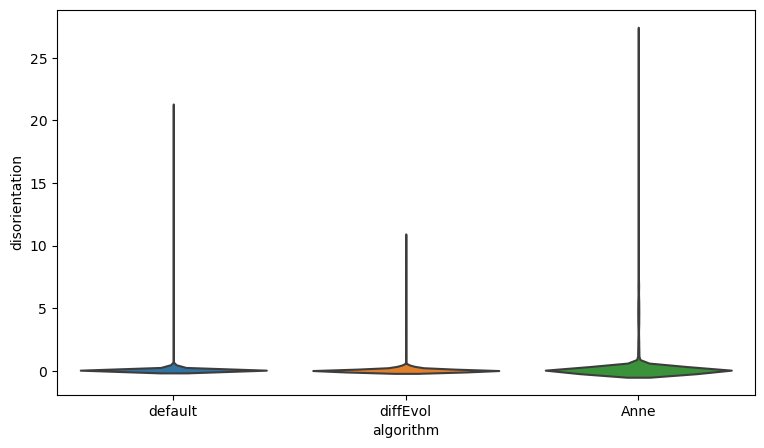

In [17]:
fig, ax = plt.subplots(figsize=(9,5))

# Plot the violin
ax = sns.violinplot(y='disorientation', 
                    x='algorithm', 
                    data=comparative,
                    scale='count',
                    inner=None
              )

In [18]:
dataset.to_csv('test_step7_env905020.csv', index=False)